In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn

Dataset loaded successfully. Shape: (7738, 18)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7738 entries, 0 to 7737
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7738 non-null   int64  
 1   price             7738 non-null   float64
 2   Address           7738 non-null   object 
 3   area              7738 non-null   float64
 4   latitude          7738 non-null   float64
 5   longitude         7738 non-null   float64
 6   Bedrooms          7738 non-null   float64
 7   Bathrooms         7738 non-null   float64
 8   Balcony           5166 non-null   float64
 9   Status            7164 non-null   object 
 10  neworold          7738 non-null   object 
 11  parking           2612 non-null   float64
 12  Furnished_status  4124 non-null   object 
 13  Lift              1733 non-null   float64
 14  Landmarks         2759 non-null   object 
 15  type_of_building  7738 non-n

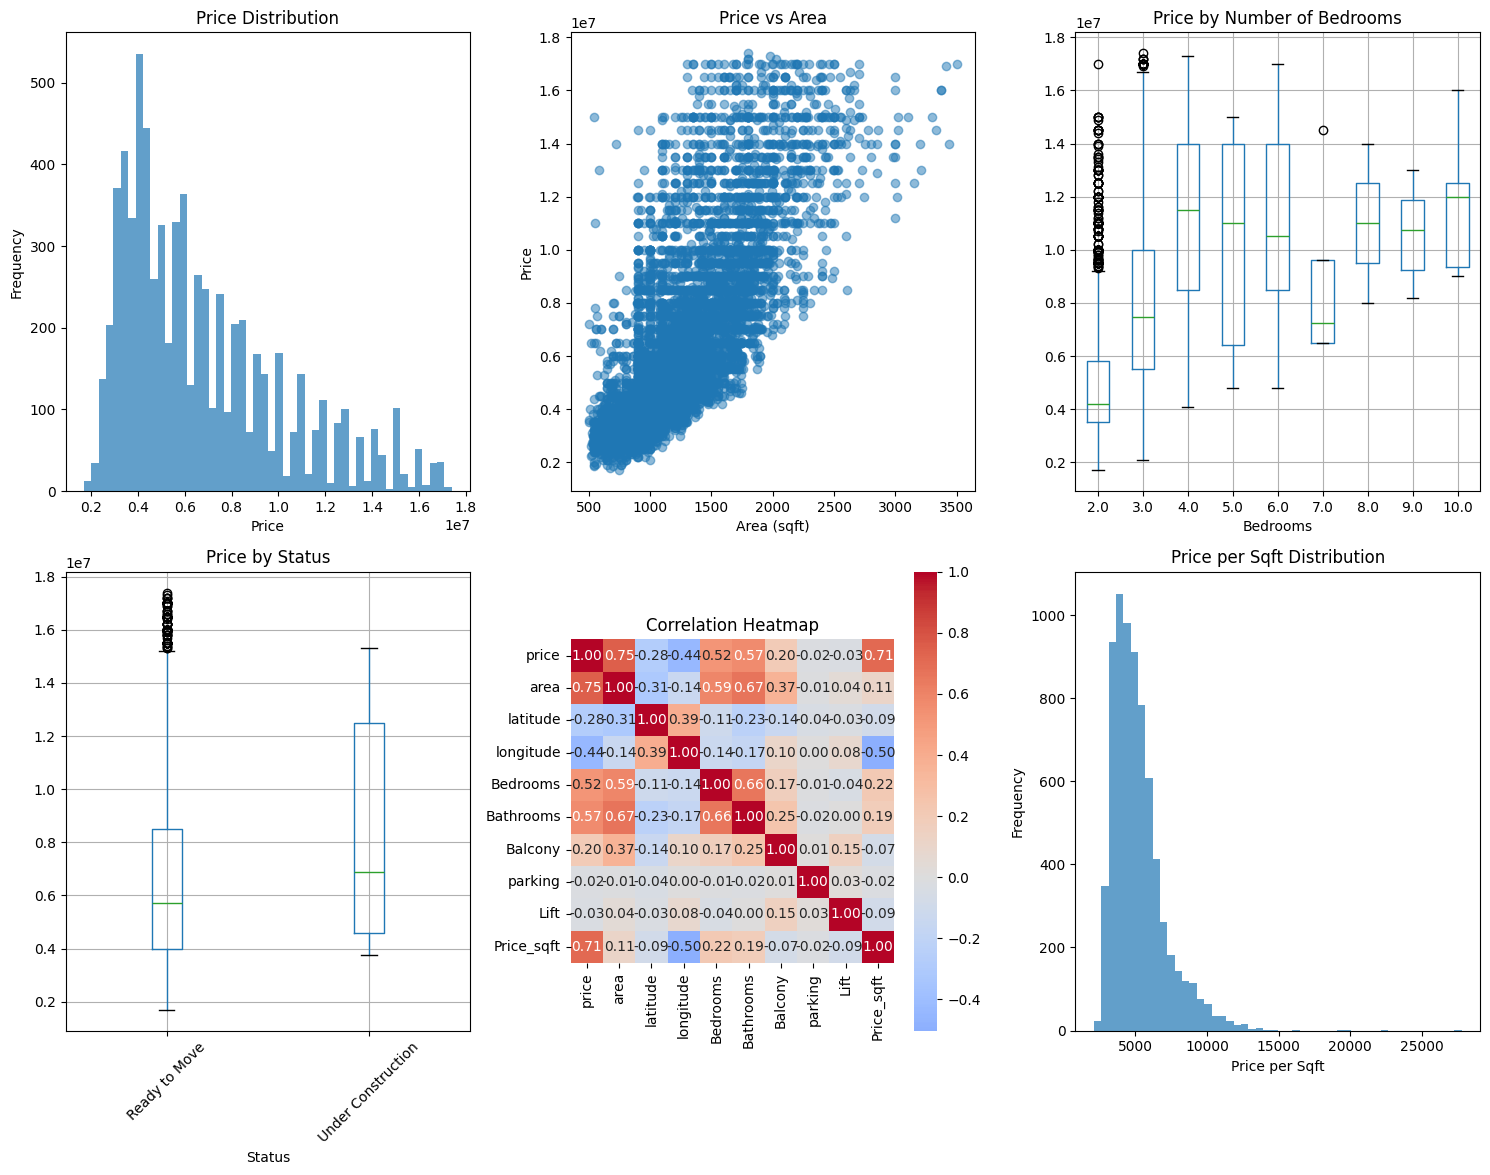


Linear Regression Results:
RMSE: 648425.96
MAE: 423802.65
R² Score: 0.9627

Ridge Regression Results:
RMSE: 648433.14
MAE: 423746.57
R² Score: 0.9627

Lasso Regression Results:
RMSE: 648425.76
MAE: 423801.87
R² Score: 0.9627

Random Forest Results:
RMSE: 169856.18
MAE: 58582.75
R² Score: 0.9974

Gradient Boosting Results:
RMSE: 193662.47
MAE: 131042.63
R² Score: 0.9967

Best performing model: Random Forest
R² Score: 0.9974


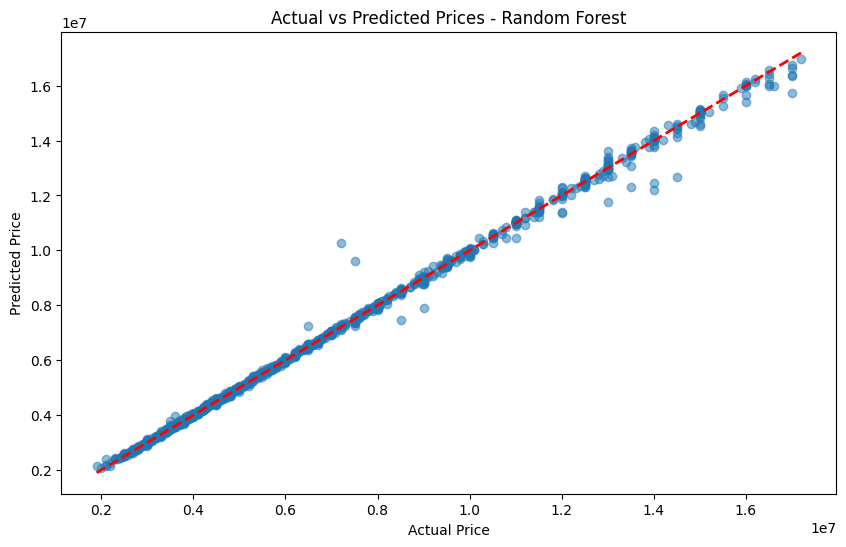

Best parameters for Random Forest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest R² Score: 0.9974


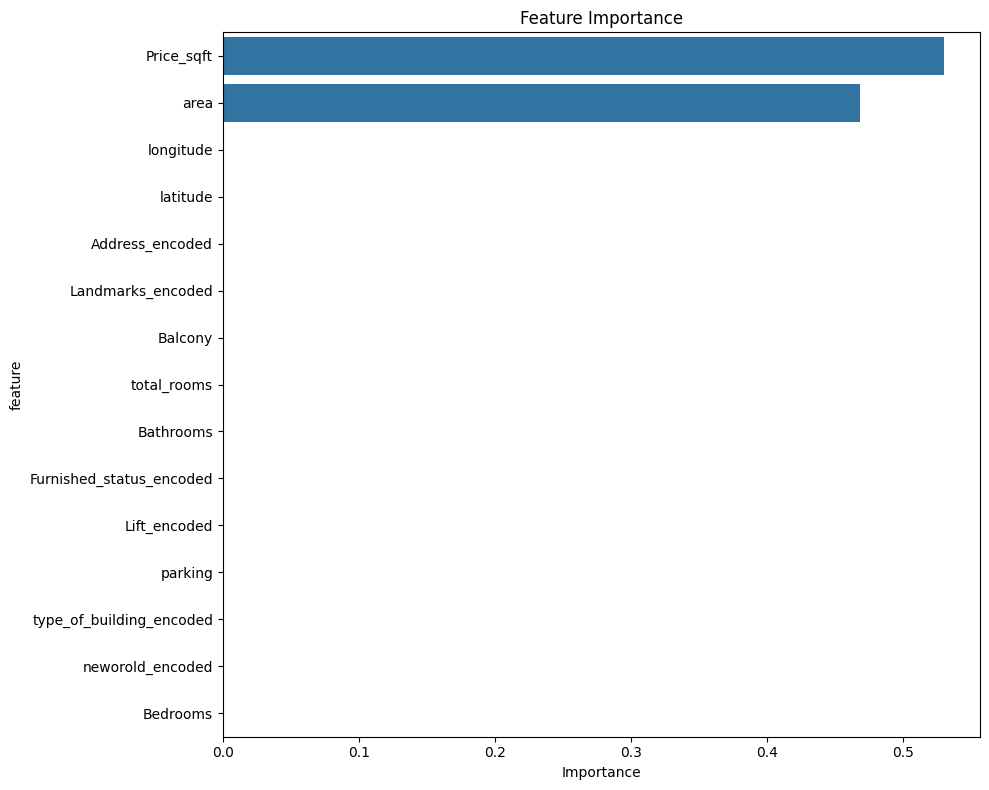

                    feature  importance
0                Price_sqft    0.529862
1                      area    0.468223
2                 longitude    0.000442
3                  latitude    0.000337
4           Address_encoded    0.000328
5         Landmarks_encoded    0.000202
6                   Balcony    0.000126
7               total_rooms    0.000088
8                 Bathrooms    0.000071
9  Furnished_status_encoded    0.000071

Model training completed.

Price Predictions for Sample Properties:

Property 1:
Area: 1250 sqft
Location: Vasundhara Enclave, New Delhi - East, Delhi NCR
Bedrooms: 3, Bathrooms: 2
Status: Ready to Move
Furnished Status: Semi-Furnished
New or Old: Resale
Type of Building: Flat
Predicted Price: ₹6,360,400
Price per sqft: ₹5,088

Property 2:
Area: 2500 sqft
Location: Noida Extension, Noida, Delhi NCR
Bedrooms: 4, Bathrooms: 3
Status: Under Construction
Furnished Status: Unfurnished
New or Old: New Property
Type of Building: Flat
Predicted Price: ₹11,161,0

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
def load_data(file_path='Delhi.csv'):
    try:
        df = pd.read_csv(file_path)
        print(f"Dataset loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print("File not found. Please ensure 'Delhi.csv' is in the current directory.")
        return None
def explore_data(df):
    print("Dataset Info:")
    print(df.info())
    print("\nDataset Description:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("\nUnique values in categorical columns:")
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"{col}: {df[col].nunique()} unique values")
def clean_data(df):
    df_clean = df.copy()
    if df_clean.columns[0] == '' or 'Unnamed' in str(df_clean.columns[0]):
        df_clean = df_clean.drop(df_clean.columns[0], axis=1)
    numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
    numerical_imputer = SimpleImputer(strategy='median')
    df_clean[numerical_cols] = numerical_imputer.fit_transform(df_clean[numerical_cols])    
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df_clean[categorical_cols] = categorical_imputer.fit_transform(df_clean[categorical_cols])    
    if 'price' in df_clean.columns:
        Q1 = df_clean['price'].quantile(0.25)
        Q3 = df_clean['price'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean['price'] >= lower_bound) & (df_clean['price'] <= upper_bound)]
    return df_clean
def feature_engineering(df):
    df_features = df.copy()    
    if 'area' in df_features.columns and 'price' in df_features.columns:
        df_features['price_per_sqft_calculated'] = df_features['price'] / df_features['area']    
    if 'Bedrooms' in df_features.columns and 'Bathrooms' in df_features.columns:
        df_features['total_rooms'] = df_features['Bedrooms'] + df_features['Bathrooms']    
    label_encoders = {}
    categorical_columns = ['Address', 'Status', 'neworold', 'Furnished_status', 
                          'Lift', 'Landmarks', 'type_of_building']
    for col in categorical_columns:
        if col in df_features.columns:
            le = LabelEncoder()
            df_features[col + '_encoded'] = le.fit_transform(df_features[col].astype(str))
            label_encoders[col] = le
    return df_features, label_encoders
def prepare_features(df):
    feature_columns = []    
    numerical_features = ['area', 'latitude', 'longitude', 'Bedrooms', 'Bathrooms', 
                         'Balcony', 'parking', 'Price_sqft']
    categorical_encoded = ['Address_encoded', 'Status_encoded', 'neworold_encoded', 
                          'Furnished_status_encoded', 'Lift_encoded', 'Landmarks_encoded', 
                          'type_of_building_encoded']
    engineered_features = ['total_rooms']    
    for feature in numerical_features + categorical_encoded + engineered_features:
        if feature in df.columns:
            feature_columns.append(feature)
    return feature_columns
def visualize_data(df):
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 3, 1)
    plt.hist(df['price'], bins=50, alpha=0.7)
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')    
    plt.subplot(2, 3, 2)
    plt.scatter(df['area'], df['price'], alpha=0.5)
    plt.title('Price vs Area')
    plt.xlabel('Area (sqft)')
    plt.ylabel('Price')
    plt.subplot(2, 3, 3)
    df.boxplot(column='price', by='Bedrooms', ax=plt.gca())
    plt.title('Price by Number of Bedrooms')
    plt.suptitle('')
    plt.subplot(2, 3, 4)
    if 'Status' in df.columns:
        df.boxplot(column='price', by='Status', ax=plt.gca())
        plt.title('Price by Status')
        plt.suptitle('')
        plt.xticks(rotation=45)
    plt.subplot(2, 3, 5)
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.subplot(2, 3, 6)
    if 'Price_sqft' in df.columns:
        plt.hist(df['Price_sqft'], bins=50, alpha=0.7)
        plt.title('Price per Sqft Distribution')
        plt.xlabel('Price per Sqft')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
def train_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)}
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {
            'model': model,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'predictions': y_pred
        }
        print(f"\n{name} Results:")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R² Score: {r2:.4f}")
    return results
def hyperparameter_tuning(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]}
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best parameters for Random Forest:")
    print(grid_search.best_params_)
    return grid_search.best_estimator_
def plot_predictions(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted Prices - {model_name}')
    plt.show()
def feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importance = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).reset_index(drop=True)
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance.head(15), x='importance', y='feature')
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        return importance
    else:
        print("Model doesn't have feature importance attribute.")
        return None
def main():
    df = load_data()
    if df is None:
        return
    explore_data(df)    
    df_clean = clean_data(df)
    print(f"Data shape after cleaning: {df_clean.shape}")
    df_features, label_encoders = feature_engineering(df_clean)
    feature_columns = prepare_features(df_features)
    print(f"Selected features: {feature_columns}")
    X = df_features[feature_columns]
    y = df_features['price']    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )
    print(f"Training set size: {X_train.shape}")
    print(f"Test set size: {X_test.shape}")
    visualize_data(df_clean)
    results = train_models(X_train, X_test, y_train, y_test)
    best_model_name = max(results.keys(), key=lambda x: results[x]['r2'])
    best_model = results[best_model_name]['model']
    best_predictions = results[best_model_name]['predictions']
    print(f"\nBest performing model: {best_model_name}")
    print(f"R² Score: {results[best_model_name]['r2']:.4f}")
    plot_predictions(y_test, best_predictions, best_model_name)
    if 'Random Forest' in results:
        tuned_rf = hyperparameter_tuning(X_train, y_train)
        tuned_predictions = tuned_rf.predict(X_test)
        tuned_r2 = r2_score(y_test, tuned_predictions)
        print(f"Tuned Random Forest R² Score: {tuned_r2:.4f}")
        importance_df = feature_importance(tuned_rf, feature_columns)
        if importance_df is not None:
            print(importance_df.head(10))
    print("\nModel training completed.\n")
    return {
        'best_model': best_model,
        'scaler': scaler,
        'label_encoders': label_encoders,
        'feature_columns': feature_columns,
        'results': results
    }
def predict_price(model_artifacts, new_data_dict):
    try:
        model = model_artifacts['best_model']
        scaler = model_artifacts['scaler']
        label_encoders = model_artifacts['label_encoders']
        feature_columns = model_artifacts['feature_columns']        
        new_data = pd.DataFrame([new_data_dict])
        if 'Bedrooms' in new_data.columns and 'Bathrooms' in new_data.columns:
            new_data['total_rooms'] = new_data['Bedrooms'] + new_data['Bathrooms']        
        categorical_mappings = {
            'Address': 'Address_encoded',
            'Status': 'Status_encoded', 
            'neworold': 'neworold_encoded',
            'Furnished_status': 'Furnished_status_encoded',
            'type_of_building': 'type_of_building_encoded'
        }
        for original_col, encoded_col in categorical_mappings.items():
            if original_col in new_data.columns and original_col in label_encoders:
                try:
                    le = label_encoders[original_col]
                    value = str(new_data[original_col].iloc[0])
                    if value in le.classes_:
                        new_data[encoded_col] = le.transform([value])
                    else:
                        new_data[encoded_col] = 0
                        print(f"Warning: '{value}' not seen in training for {original_col}. Using default encoding.")
                except:
                    new_data[encoded_col] = 0        
        for col in feature_columns:
            if col not in new_data.columns:
                if 'encoded' in col:
                    new_data[col] = 0  
                elif col in ['latitude', 'longitude']:
                    new_data['latitude'] = 28.6139 if col == 'latitude' else new_data.get('latitude', 28.6139)
                    new_data['longitude'] = 77.2090 if col == 'longitude' else new_data.get('longitude', 77.2090)
                elif col in ['Balcony', 'parking', 'Lift']:
                    new_data[col] = 1 
                elif col == 'Price_sqft':
                    new_data[col] = 5000  
                else:
                    new_data[col] = 0
        X_new = new_data[feature_columns]
        X_new_scaled = scaler.transform(X_new)
        predicted_price = model.predict(X_new_scaled)[0]        
        return predicted_price
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        return None
def predict_sample_properties():
    sample_properties = [
        {
            'area': 1250,
            'Address': 'Vasundhara Enclave, New Delhi - East, Delhi NCR',
            'Bedrooms': 3,
            'Bathrooms': 2,
            'Status': 'Ready to Move',
            'Furnished_status': 'Semi-Furnished',
            'neworold': 'Resale',
            'type_of_building': 'Flat',
            'Balcony': 1,
            'parking': 1,
            'Lift': 1,
            'latitude': 28.6139,
            'longitude': 77.2090,
            'Price_sqft': 5000
        },
        {
            'area': 2500,
            'Address': 'Noida Extension, Noida, Delhi NCR',
            'Bedrooms': 4,
            'Bathrooms': 3,
            'Status': 'Under Construction',
            'Furnished_status': 'Unfurnished',
            'neworold': 'New Property',
            'type_of_building': 'Flat',
            'Balcony': 2,
            'parking': 2,
            'Lift': 1,
            'latitude': 28.5355,
            'longitude': 77.3910,
            'Price_sqft': 4500
        },
        {
            'area': 1600,
            'Address': 'Sector 81, Gurgaon, Delhi NCR',
            'Bedrooms': 3,
            'Bathrooms': 2,
            'Status': 'Ready to Move',
            'Furnished_status': 'Furnished',
            'neworold': 'Resale',
            'type_of_building': 'Flat',
            'Balcony': 1,
            'parking': 1,
            'Lift': 1,
            'latitude': 28.4595,
            'longitude': 77.0266,
            'Price_sqft': 5500
        }
    ]
    return sample_properties
if __name__ == "__main__":
    model_artifacts = main()
    if model_artifacts:
        print("Price Predictions for Sample Properties:")
        sample_properties = predict_sample_properties()
        for i, property_data in enumerate(sample_properties, 1):
            print(f"\nProperty {i}:")
            print(f"Area: {property_data['area']} sqft")
            print(f"Location: {property_data['Address']}")
            print(f"Bedrooms: {property_data['Bedrooms']}, Bathrooms: {property_data['Bathrooms']}")
            print(f"Status: {property_data['Status']}")
            print(f"Furnished Status: {property_data['Furnished_status']}")
            print(f"New or Old: {property_data['neworold']}")
            print(f"Type of Building: {property_data['type_of_building']}")
            predicted_price = predict_price(model_artifacts, property_data)
            if predicted_price:
                print(f"Predicted Price: ₹{predicted_price:,.0f}")
                print(f"Price per sqft: ₹{predicted_price/property_data['area']:,.0f}")
            else:
                print("Could not predict price for this property.")
print("\n")